### Plant Seedling Classification

 importing important libraries

In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
TRAin_DATA_FOLDER= "/content/drive/My Drive/train"

 **Reading image and removing missing value and saving the image to images list**

In [ ]:
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missig value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

## Resizing image

In [ ]:
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res
#resized=[]
#for image in images:
#  ressized= resize_images(images[image])

In [ ]:
#save resized images into images.
images = [resize_images(img) for img in images]

## number of image in each class

In [ ]:
#see number of images in each lablel
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)
#for key,value in images_per_class.items():
   # print("number of {0} images is  -> {1}".format(key, len(value)))
  
for label in set(classes):

  print("number of {} images is  -> {}".format(
        label, 
        len(images[classes == label])))

images shape:  (2003, 256, 256, 3)
classes shape:  (2003,)
number of Common wheat images is  -> 54
number of Loose Silky-bent images is  -> 342
number of Fat Hen images is  -> 225
number of Scentless Mayweed images is  -> 261
number of Cleavers images is  -> 54
number of Sugar beet images is  -> 135
number of Common Chickweed images is  -> 351
number of Charlock images is  -> 144
number of Small-flowered Cranesbill images is  -> 234
number of Maize images is  -> 72
number of Shepherds Purse images is  -> 68
number of Black-grass images is  -> 63


## Plot distribution of image in each class

Text(0.5, 0.98, 'Categorical Plotting')

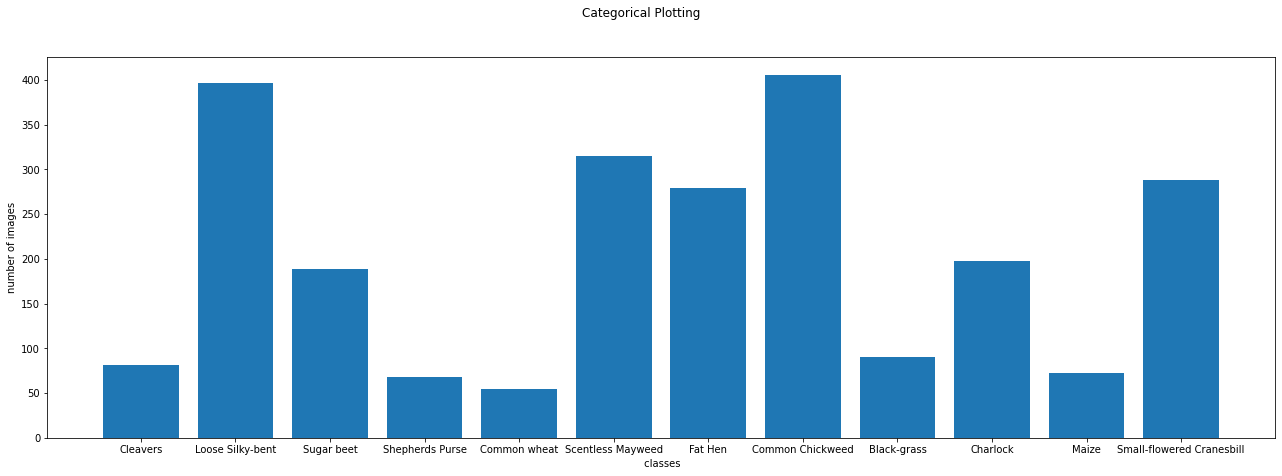

In [ ]:
values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values)
ax.set_xlabel(" classes")
ax.set_ylabel("number of images")
#axs[1].scatter(label, )
  #axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

## Applying image processing on the image

In [ ]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

## Put all function together

In [ ]:
def segment(img):

  #image_mask = create_mask_for_plant(img)
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

# iterate the image

In [ ]:
for indx, image in enumerate(images):
  try:
     images[indx] = segment(image)
      
  except:
    print(indx)
    continue

## label encoder

In [ ]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes)

## split dataset into training and testing set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

## create validation set

In [ ]:

random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

## CNN model

In [ ]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Set the CNN model 

batch_size = None

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,256, 256, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))



model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(12, activation = "softmax"))
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)       

In [ ]:
opt = Adam(lr=0.01)

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkpointer = ModelCheckpoint(filepath='cnn_model_wo_aug_af3.hdf5', 
                               verbose=1, save_best_only=True)

In [ ]:
 #I'm using colab for good resaon  :D 
 #I put epochs = 50 and I waited until it reach a acceptable accuracy for me then I stopped the training at this point.
model.fit(X_train, y_train, epochs = 20, validation_data = (X_val,Y_val),callbacks=[checkpointer],batch_size = batch_size)




Train on 2173 samples, validate on 466 samples
Epoch 1/20
2173/2173 [==============================] - 1393s 641ms/step - loss: 2.3902 - accuracy: 0.1841 - val_loss: 2.3493 - val_accuracy: 0.1524

Epoch 00001: val_loss improved from inf to 2.34933, saving model to cnn_model_wo_aug_af.hdf5
Epoch 2/20
1696/2173 [======================>.......] - ETA: 4:51 - loss: 2.2064 - accuracy: 0.2506

In [ ]:
model.load_weights('/content/cnn_model_wo_aug_af1.hdf5')
accuracy=model.evaluate(x=X_test,y=y_test,batch_size=38)
print("Loss of the model: {} , Accuracy of Model :{} ".format(accuracy[0],accuracy[1]))

## accuracy of the *model*

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0134511111631925
Test accuracy: 0.6716738343238831


In [ ]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

Different speices

In [ ]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [ ]:
SAMPLE_PER_CATEGORY = 200
SEED = 1987
data_dir = '/content/drive/My Drive/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['{}/{}/{}'.format(train_dir,category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head(2)
train.shape

(2003, 3)

In [ ]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img


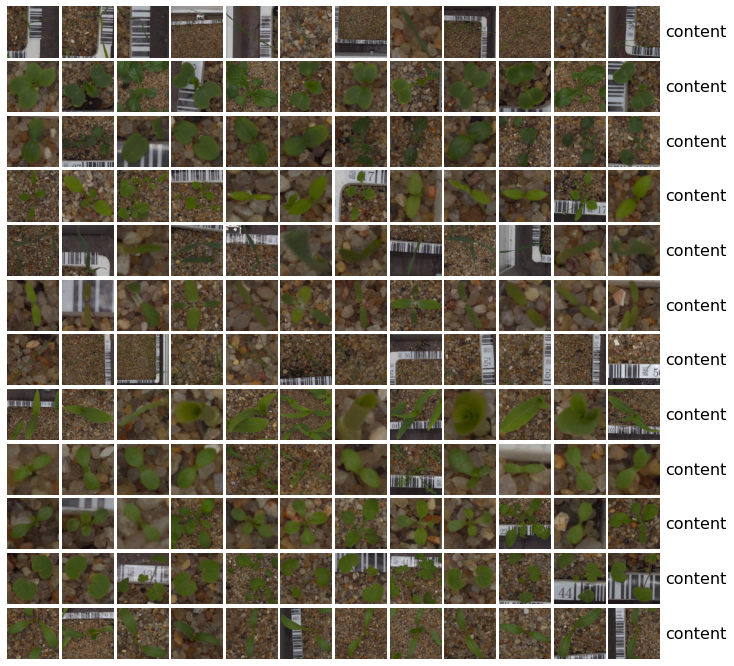

In [ ]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

## Extract Xception bottleneck features

In [ ]:
NPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

2003it [00:33, 59.53it/s]

Train Images shape: (2003, 299, 299, 3) size: 537,210,609


In [ ]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(1592, 411)

In [ ]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1592, 299, 299, 3), (411, 299, 299, 3), (1592,), (411,))
411/411 [==============================] - 190s 461ms/step
Xception train bottleneck features shape: (1592, 2048) size: 3,260,416
Xception valid bottleneck features shape: (411, 2048) size: 841,728


## LogReg on Xception bottleneck features

In [ ]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, ytr)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print('Validation Xception Accuracy {}'.format(accuracy_score(yv, valid_preds)))

Validation Xception Accuracy 0.851581508515815


## Confusion matrix

In [ ]:
cnf_matrix = confusion_matrix(yv, valid_preds)

In [ ]:
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})

,class,abbreviation
0,Black-grass,BG
1,Charlock,Ch
2,Cleavers,Cl
3,Common Chickweed,CC
4,Common wheat,CW
5,Fat Hen,FH
6,Loose Silky-bent,LSB
7,Maize,M
8,Scentless Mayweed,SM
9,Shepherds Purse,SP


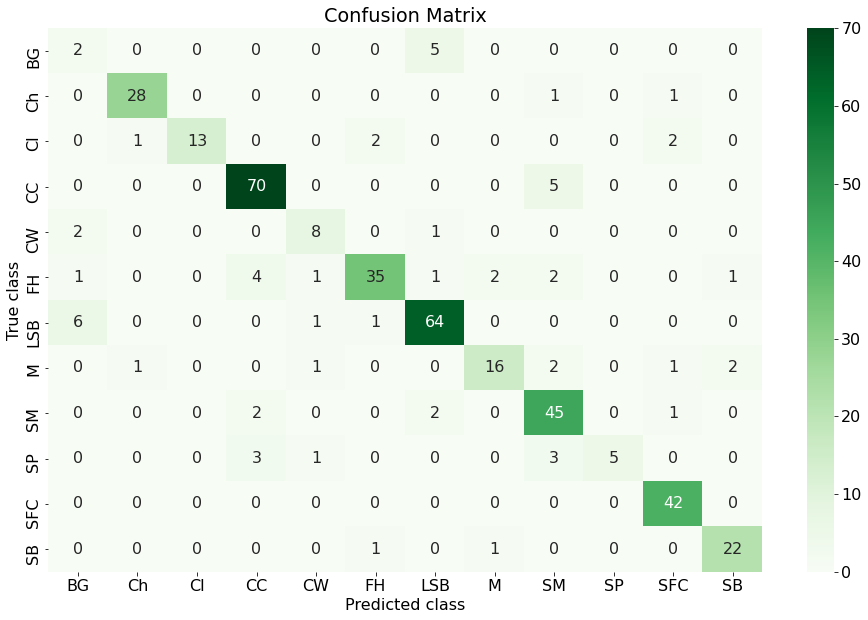

In [ ]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show();

# Increasing epochs to 30

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
import cv2
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
import time
%matplotlib inline

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Sequential, model_from_json
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense ,Input
from keras.optimizers import Adam ,RMSprop

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
  def load_dataset(path):
    data=load_files(path)
    plant_files=np.array(data['filenames'])
    plant_targets=np_utils.to_categorical(np.array(data['target']),12)
    return plant_files,plant_targets

print('Loading Train Files and Targets')
train_files, train_targets = load_dataset('/content/drive/My Drive/train')
print('Loading Complete!')
print('There are %d training plant images.' % len(train_files))

Loading Train Files and Targets
Loading Complete!
There are 2435 training plant images.


In [ ]:
categories = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
no_categories = len(categories)

In [ ]:
plant_names= [item[58:-1] for item in sorted(glob("/content/drive/My Drive/train/*/"))]
print('There are %d total plant categories.' % len(plant_names))

There are 12 total plant categories.


In [ ]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(256, 256))
    # convert PIL.Image.Image type to 3D tensor with shape (256, 256, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 256, 256, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255

100%|██████████| 2435/2435 [00:33<00:00, 73.17it/s]


In [ ]:
train_tensors.shape

(2435, 256, 256, 3)

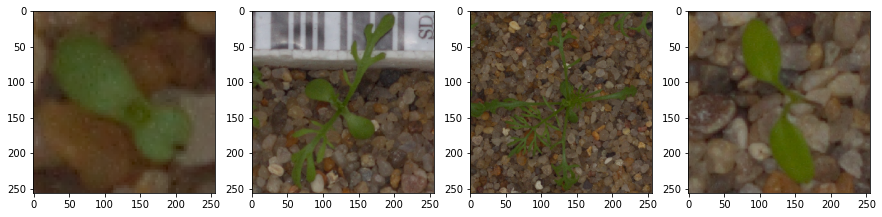

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15,15))

axs[0].imshow(train_tensors[0])
axs[1].imshow(train_tensors[10])
axs[2].imshow(train_tensors[42])
axs[3].imshow(train_tensors[65])

## plotting image with pixel value

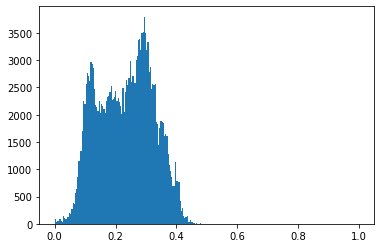

In [ ]:
plt.hist(train_tensors[0].ravel(),256,[0,1])
plt.show()

In [ ]:
# do not change seed to reproduce my results
seed = 31
np.random.seed(seed)



# Split the train and the validation set
train_tensors, val_train, train_targets, val_targets = train_test_split(train_tensors,
                                              train_targets, 
                                              test_size=0.15,
                                              random_state=seed
                                             )

print(train_tensors.shape)
print(val_train.shape)
print(train_targets.shape)
print(val_targets.shape)


(2069, 256, 256, 3)
(366, 256, 256, 3)
(2069, 12)
(366, 12)


In [ ]:
model= Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))


model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(GlobalAveragePooling2D())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(12,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      12832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)       

In [ ]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
#checkpointer = ModelCheckpoint(filepath='cnn_model_wo_aug_af1.hdf5', 
#                               verbose=1, save_best_only=True)
#
#history = model.fit(train_tensors, train_targets, epochs = 30, validation_data = (val_train,val_targets),callbacks=[checkpointer],batch_size = 64)

Train on 2069 samples, validate on 366 samples
Epoch 1/30
2069/2069 [==============================] - 477s 231ms/step - loss: 2.4626 - accuracy: 0.1566 - val_loss: 2.3003 - val_accuracy: 0.1475

Epoch 00001: val_loss improved from inf to 2.30029, saving model to cnn_model_wo_aug_af1.hdf5
Epoch 2/30
2069/2069 [==============================] - 476s 230ms/step - loss: 2.3164 - accuracy: 0.1551 - val_loss: 2.3636 - val_accuracy: 0.1475

Epoch 00002: val_loss did not improve from 2.30029
Epoch 3/30
2069/2069 [==============================] - 476s 230ms/step - loss: 2.3088 - accuracy: 0.1609 - val_loss: 2.3067 - val_accuracy: 0.1475

Epoch 00003: val_loss did not improve from 2.30029
Epoch 4/30
2069/2069 [==============================] - 477s 230ms/step - loss: 2.2925 - accuracy: 0.1677 - val_loss: 3.7528 - val_accuracy: 0.1831

Epoch 00004: val_loss did not improve from 2.30029
Epoch 5/30
2069/2069 [==============================] - 476s 230ms/step - loss: 2.2714 - accuracy: 0.2363 - va

In [ ]:
model.load_weights('cnn_model_wo_aug_af1.hdf5')
accuracy=model.evaluate(x=val_train,y=val_targets,batch_size=32)
print("Loss of the model: {} , Accuracy of Model :{} ".format(accuracy[0],accuracy[1]))

366/366 [==============================] - 21s 57ms/step
Loss of the model: 1.0144061964066302 , Accuracy of Model :0.6857923269271851 


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


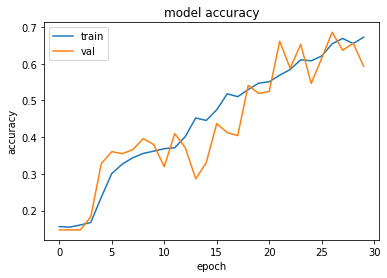

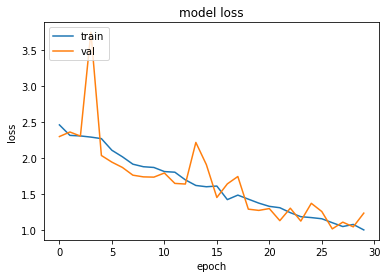

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def one_hot_to_dense(labels_one_hot):
    num_labels = labels_one_hot.shape[0]
    num_classes = labels_one_hot.shape[1]
    labels_dense = np.where(labels_one_hot == 1)[1]      
    return labels_dense

In [ ]:
validation_predictions = model.predict_classes(val_train)
report=classification_report(one_hot_to_dense(val_targets),validation_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.69      0.96      0.80        25
           2       0.50      0.17      0.25        12
           3       0.84      0.91      0.87        67
           4       0.00      0.00      0.00         9
           5       0.75      0.51      0.61        41
           6       0.69      0.93      0.79        54
           7       0.80      0.25      0.38        16
           8       0.49      0.86      0.62        43
           9       0.00      0.00      0.00         8
          10       0.68      0.75      0.71        48
          11       1.00      0.53      0.70        30

    accuracy                           0.69       366
   macro avg       0.54      0.49      0.48       366
weighted avg       0.67      0.69      0.65       366



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
           'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_species = len(species)
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': species, 'abbreviation': abbreviation})

,class,abbreviation
0,Black-grass,BG
1,Charlock,Ch
2,Cleavers,Cl
3,Common Chickweed,CC
4,Common wheat,CW
5,Fat Hen,FH
6,Loose Silky-bent,LSB
7,Maize,M
8,Scentless Mayweed,SM
9,Shepherds Purse,SP


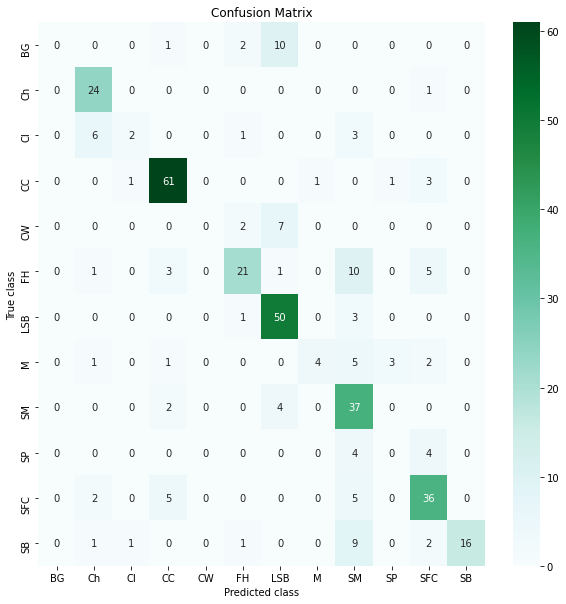

In [ ]:
conf_mat= confusion_matrix(one_hot_to_dense(val_targets), validation_predictions)
fig, ax = plt.subplots(1,figsize=(10,10))

ax = sns.heatmap(conf_mat, ax=ax, cmap=plt.cm.BuGn, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

In [ ]:
model_json = model.to_json()
with open("model_after_rev.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_after_rev.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
def plant_seed_classification(image):
    
    image = path_to_tensor(image).astype('float32')/255
    
    json_file = open('model_after_rev.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("model_after_rev.h5")
    print("Loaded model from disk")
    
    prediction = model.predict_classes(image)
    
    print('The predicted Class of the image is {}'.format(prediction))
    INV_CLASS = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'
     }
    print('The class of the plant is',[INV_CLASS[p] for p in prediction])

In [ ]:
plant_seed_classification('black_grass.png')

Loaded model from disk
The predicted Class of the image is [6]
The class of the plant is ['Loose Silky-bent']


# Increasing epochs to 50

In [ ]:
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16

def vgg16_model(num_classes=None):

    model = VGG16(weights='imagenet', include_top=False,input_shape=(128,128,3))
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()

    model.outputs = [model.layers[-1].output]

    model.layers[-2].outbound_nodes= []
    x=Conv2D(256, kernel_size=(2,2),strides=2)(model1.output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)    
    x=Conv2D(128, kernel_size=(2,2),strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x=Flatten()(x)
    x=Dense(num_classes, activation='softmax')(x)

    model=Model(model.input,x)

    for layer in model.layers[:15]:

        layer.trainable = False


    return model

In [ ]:

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

In [ ]:
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(128,128), interpolation = cv2.INTER_CUBIC)
  return res

In [ ]:
#checkpointer = ModelCheckpoint(filepath='cnn_model_wo_aug_af2.hdf5', 
 #                              verbose=1, save_best_only=True)

In [ ]:
#history = model.fit(train_tensors, train_targets, epochs = 50, validation_data = (val_train,val_targets),callbacks=[checkpointer],batch_size = 100)

Train on 2069 samples, validate on 366 samples
Epoch 1/50
2069/2069 [==============================] - 445s 215ms/step - loss: 2.4760 - accuracy: 0.1493 - val_loss: 2.3150 - val_accuracy: 0.1475

Epoch 00001: val_loss improved from inf to 2.31500, saving model to cnn_model_wo_aug_af2.hdf5
Epoch 2/50
2069/2069 [==============================] - 443s 214ms/step - loss: 2.3101 - accuracy: 0.1561 - val_loss: 2.3495 - val_accuracy: 0.1475

Epoch 00002: val_loss did not improve from 2.31500
Epoch 3/50
2069/2069 [==============================] - 443s 214ms/step - loss: 2.3123 - accuracy: 0.1609 - val_loss: 2.3255 - val_accuracy: 0.1475

Epoch 00003: val_loss did not improve from 2.31500
Epoch 4/50
2069/2069 [==============================] - 443s 214ms/step - loss: 2.2897 - accuracy: 0.1721 - val_loss: 2.3537 - val_accuracy: 0.1475

Epoch 00004: val_loss did not improve from 2.31500
Epoch 5/50
2069/2069 [==============================] - 442s 214ms/step - loss: 2.2676 - accuracy: 0.2141 - va

In [ ]:
model.load_weights('cnn_model_wo_aug_af2.hdf5')
accuracy=model.evaluate(x=val_train,y=val_targets,batch_size=32)
print("Loss of the model: {} , Accuracy of Model :{} ".format(accuracy[0],accuracy[1]))

366/366 [==============================] - 21s 58ms/step
Loss of the model: 0.774016353276258 , Accuracy of Model :0.7568305730819702 


In [ ]:
def one_hot_to_dense(labels_one_hot):
    num_labels = labels_one_hot.shape[0]
    num_classes = labels_one_hot.shape[1]
    labels_dense = np.where(labels_one_hot == 1)[1]      
    return labels_dense

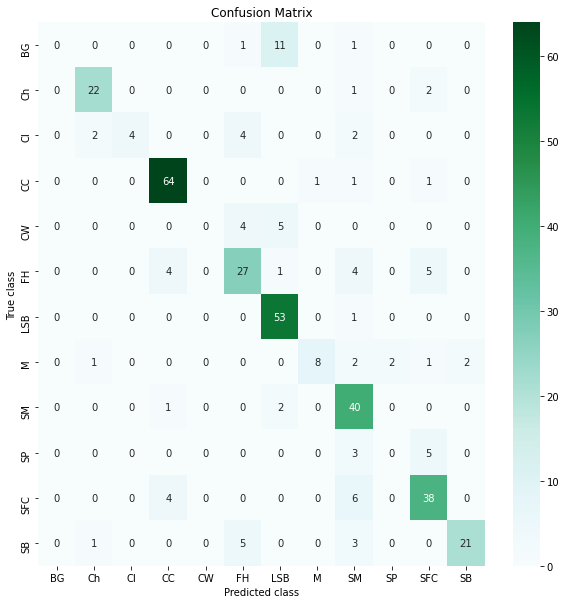

In [ ]:
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
           'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_species = len(species)
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': species, 'abbreviation': abbreviation})
conf_mat= confusion_matrix(one_hot_to_dense(val_targets), validation_predictions)
fig, ax = plt.subplots(1,figsize=(10,10))

ax = sns.heatmap(conf_mat, ax=ax, cmap=plt.cm.BuGn, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
n_estimators = 500
max_depth = 100

reshaped_x_train = X_train.reshape(X_train.shape[0], -1)

rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
rf_model.fit(reshaped_x_train, y_train.argmax(1))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn.externals import joblib
joblib.dump(rf_model, "RF_Model.h5")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['RF_Model.h5']

In [ ]:
import pandas as pd

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    recall = recall(y_true, y_pred)
    precision = precision(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [ ]:
from sklearn import metrics

reshaped_x_val = X_test.reshape(X_test.shape[0], -1)

rf_model = joblib.load("RF_Model.h5")
rf_preds = rf_model.predict(reshaped_x_val)
rf_proba = rf_model.predict_proba(reshaped_x_val)

idx = len(results) +1
results.loc[idx] = ['Random Forests',
                       metrics.accuracy_score(y_test.argmax(1), rf_preds),
                       metrics.precision_score(y_test.argmax(1), rf_preds, average="macro"),
                       metrics.recall_score(y_test.argmax(1), rf_preds, average="macro"),
                       metrics.f1_score(y_test.argmax(1), rf_preds, average="macro") ]
results


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy,Precision,Recall,F1
1,Random Forests,0.673333,0.507142,0.463107,0.43561
2,Random Forests,0.673333,0.507142,0.463107,0.43561


## Using Support Vector Machine

In [ ]:
input_shape = X_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (256, 256, 3)


In [ ]:
SPECIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
              'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse',
              'Small-flowered Cranesbill', 'Sugar beet']



extracting feature from last layer of CNN model

In [ ]:
model_feat = Model(inputs=model_new.input,outputs=model_new.get_layer('dense_4').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_test)
print(feat_val.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

(1402, 512)
(300, 512)
(300, 512)


Applying SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


## Score on training feature

In [ ]:
svm.score(feat_train,np.argmax(y_train,axis=1))

0.6426533523537803

## score on testing feature

In [ ]:
svm.score(feat_val,np.argmax(y_test,axis=1))

0.5533333333333333

## Applying XGBOOST

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier()

xb.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


## score on training feature

In [ ]:
xb.score(feat_train,np.argmax(y_train,axis=1))

1.0

### score on testing feature

In [ ]:
xb.score(feat_val,np.argmax(y_test,axis=1))

0.56